# Кластеризация

[Кластеризация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) - это один из видов задач обучения без учителя. Задача заключается в разбиении всех объектов на группы похожих между собой объектов и сильно отличающихся от всех остальных. Так как строгого понятия похожести объектов как такового нет, то алгоритмов кластеризации много, да и каждый алгоритм имеет много вариантов работы.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

## KMeans

Метод k-means - это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.
Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.
Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам: $$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$
Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости.
Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1. Этап кластеризациu. На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2. Этап обновления центроидов. На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума, а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

_взято из материалов курса [ODS](https://habrahabr.ru/company/ods/)_

### Литература

- http://scikit-learn.org/stable/modules/clustering.html
- https://habrahabr.ru/company/ods/blog/325654/
- https://ru.wikipedia.org/wiki/Кластерный_анализ

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# Зафиксируем случайность, чтобы каждый раз получалось одно и тоже
np.random.seed(seed=42)

Рассмотрим как работае алгоритм кластеризации KMeans на синтетическом примере.

Бросим на плоскость случайно точки с разными параметрами случайности, чтобы образовались кластеры.

In [3]:
import sklearn
sklearn.__version__

'0.19.1'

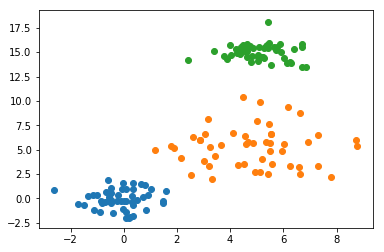

In [3]:
p1 = np.random.normal(loc=0, scale=1, size=(50,2))
p2 = np.random.normal(loc=5, scale=2, size=(50,2))
p3 = np.random.normal(loc=10, scale=0.8, size=(50,2)) - np.array([5, -5])

X = np.concatenate((p1, p2, p3))

plt.scatter(p1[:,0], p1[:, 1])
plt.scatter(p2[:,0], p2[:, 1])
plt.scatter(p3[:,0], p3[:, 1])

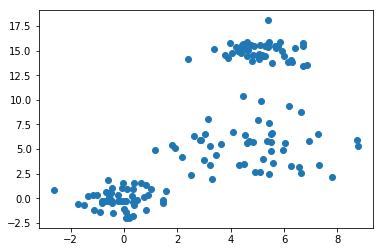

In [4]:
plt.scatter(X[:, 0], X[:, 1])

Рассмотрим пошагово работу алгоритма KMneans на основе обычного евклидова расстояния.

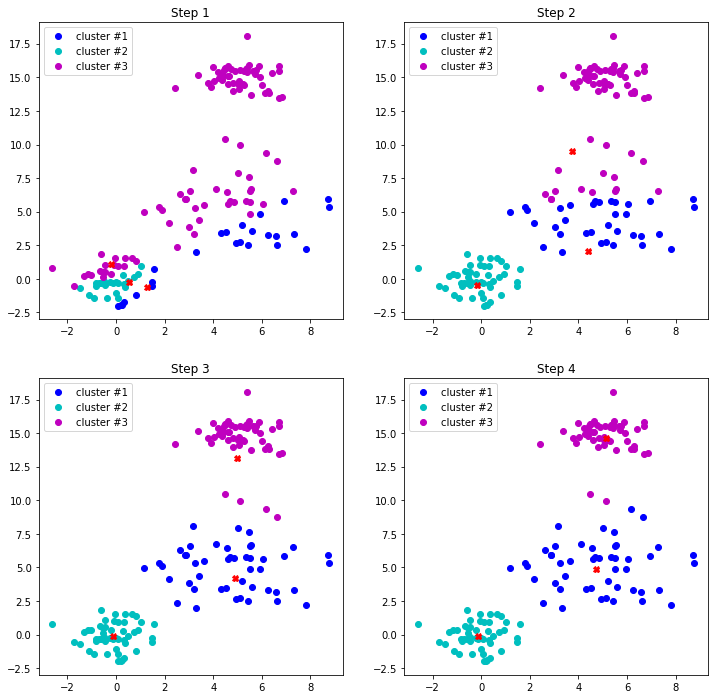

In [6]:
# Пример взят отсюда: https://habrahabr.ru/company/ods/blog/325654/

# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
from scipy.spatial.distance import cdist

centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

STEPS = 3

for i in range(STEPS):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)
    

# А теперь нарисуем всю эту красоту
plt.figure(figsize=(12, 12))
for i in range(STEPS + 1):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

# MNIST

Рассморим датасет рукописных цирф MNIST http://yann.lecun.com/exdb/mnist/

In [294]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


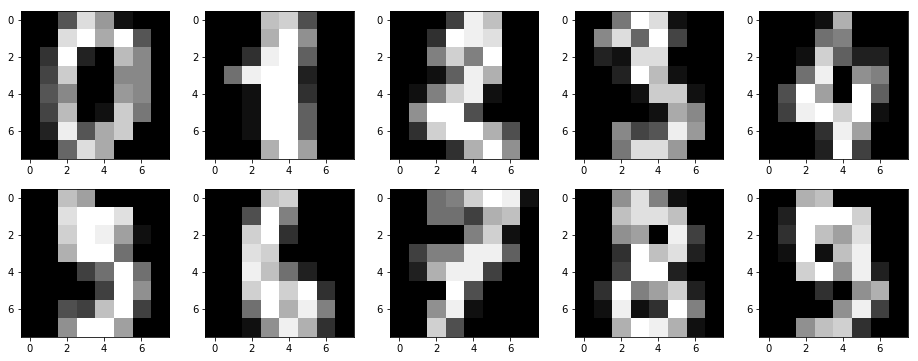

In [295]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray')

In [297]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=10)
clf.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA -  [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

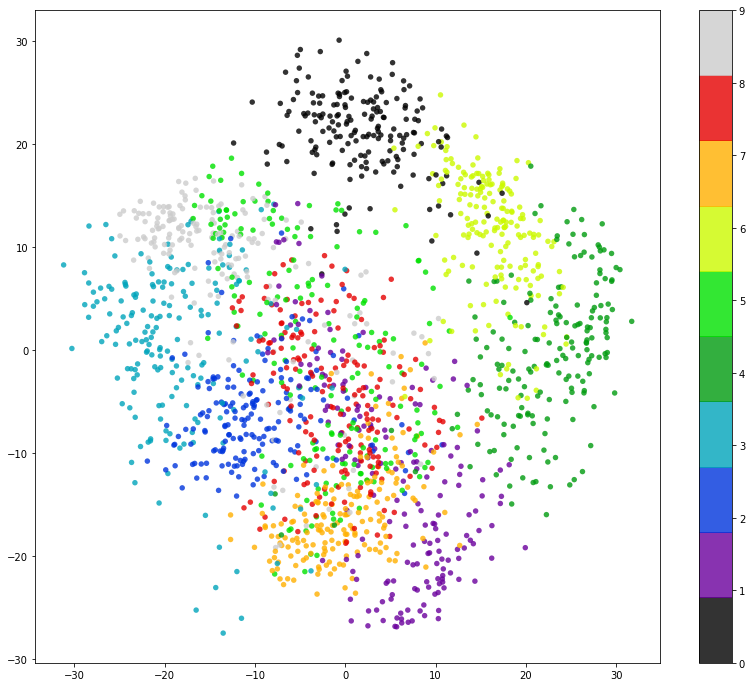

In [319]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)

X_reduced = pca.fit_transform(X)
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

А теперь посмотрим как расставил границы наш алгоритм KMeans. Как видим - хоть цвета и перепутаны, но сами кластеры угадываются.

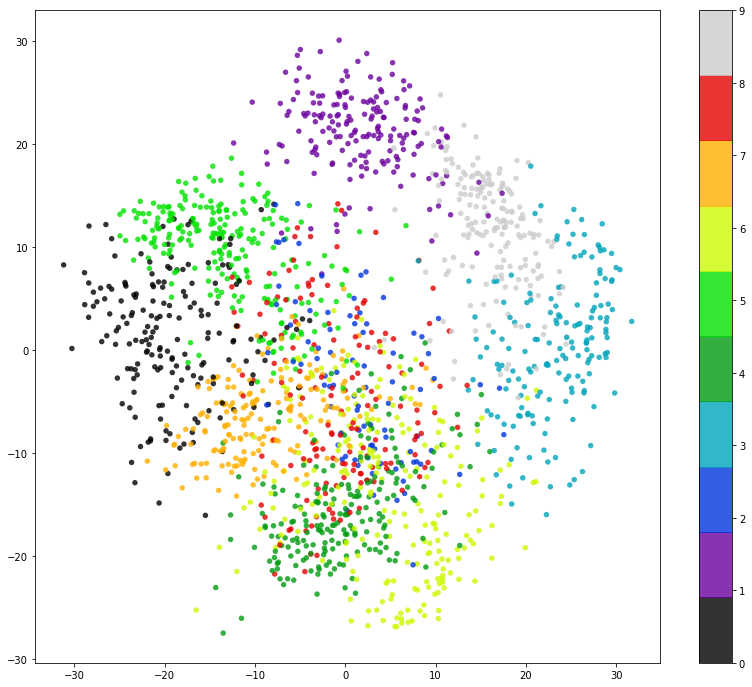

In [317]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=clf.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Визуализируем центры кластеров как изображения. Как видим они даже похожи на настоящие цифры.

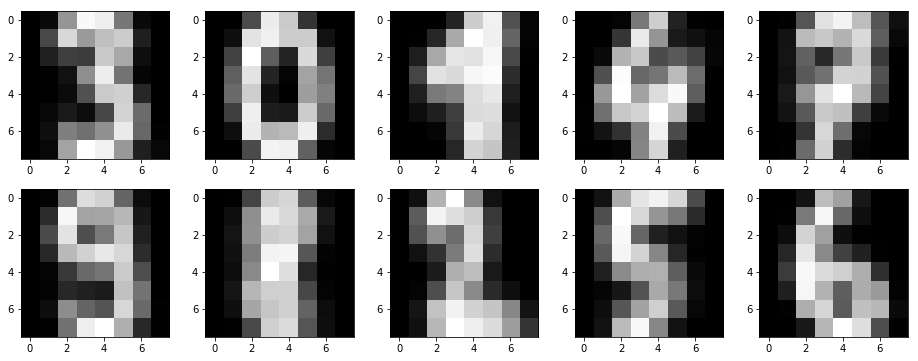

In [318]:
plt.figure(figsize=(16, 6))

for i, center in enumerate(clf.cluster_centers_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center[:].reshape([8,8]), cmap='gray')

Существуют и другие методы понижения размерности, например t-SNE, но он намного медленнее чем PCA.

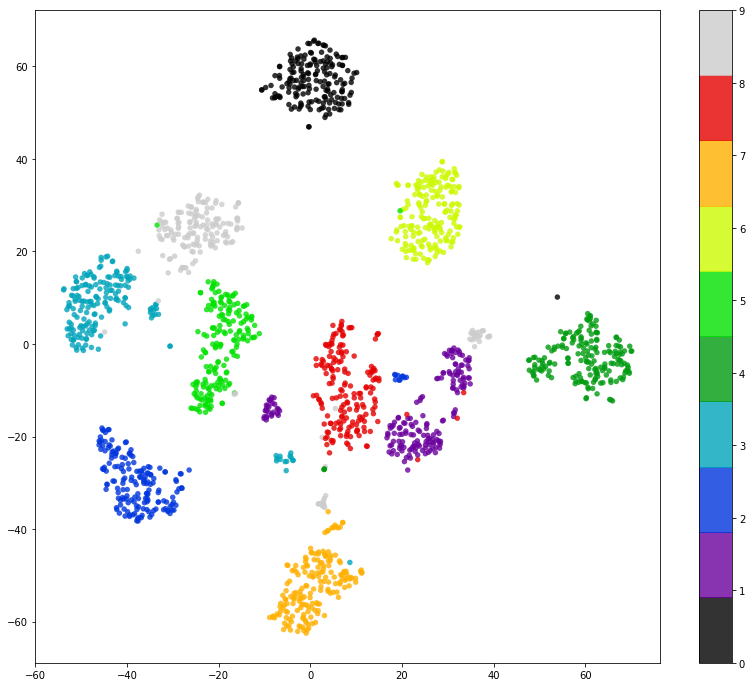

In [320]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_reduced_t = tsne.fit_transform(X)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

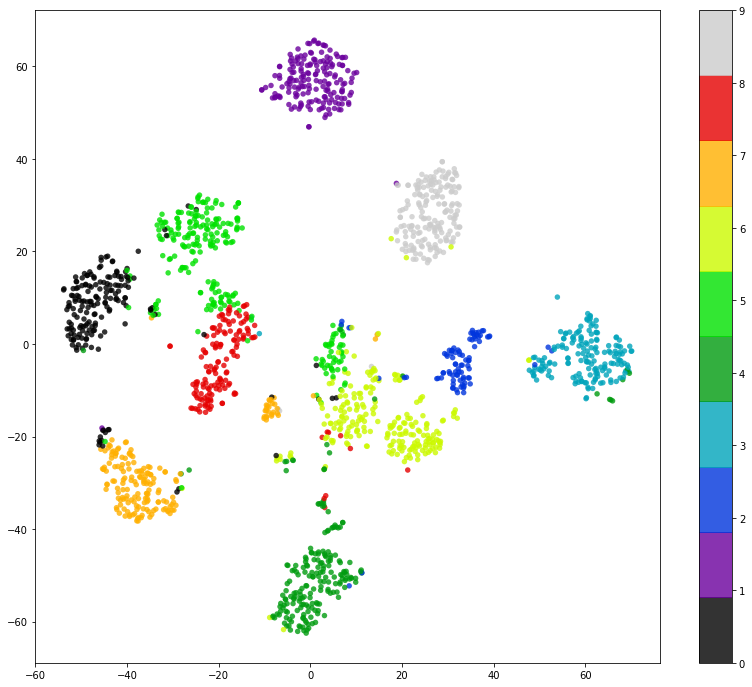

In [321]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=clf.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

## Кластеризация рекомендаций фильмов

In [4]:
movies = pd.read_csv('../../data/imdb_movies.csv.gz', index_col='movieId')
ratings = pd.read_csv('../../data/imdb_ratings.csv.gz')

print(movies.shape)
print(ratings.shape)

(9125, 2)
(100004, 4)


In [10]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [117]:
# ratings.pivot_table(index='movieId', values='rating', columns='userId',dropna=True)

In [5]:
from itertools import chain
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

In [6]:
genres = set(flatmap(
    lambda x: x.split("|"), 
    movies['genres'].unique()))

genres.remove('(no genres listed)')
genres.remove('IMAX')
genres = list(genres)
print(genres)

['Documentary', 'Film-Noir', 'Drama', 'Thriller', 'Mystery', 'Comedy', 'Horror', 'Crime', 'Action', 'Musical', 'Animation', 'Sci-Fi', 'Children', 'Adventure', 'Fantasy', 'Western', 'Romance', 'War']


In [7]:
movies_genres = pd.DataFrame(index=movies.index)
for g in genres:
    movies_genres[g] = movies['genres'].str.contains(g).astype(int)
print(movies_genres.shape)
movies_genres.head()

(9125, 18)


,Documentary,Film-Noir,Drama,Thriller,Mystery,Comedy,Horror,Crime,Action,Musical,Animation,Sci-Fi,Children,Adventure,Fantasy,Western,Romance,War
movieId,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [99]:
df = ratings.join(movies_genres, on='movieId').drop(['timestamp', 'movieId'], axis=1)
df[genres] = df[genres].multiply(df['rating'], axis='index')
df = df.drop(['rating'], axis=1).replace(0, np.NaN) # чтобы посчитать mean без учета непросмотренных фильмов
df = df.groupby('userId').mean()
df.fillna(-1, inplace=True)
print(df.shape)
df.head()

(671, 18)


,Documentary,Film-Noir,Drama,Thriller,Mystery,Comedy,Horror,Crime,Action,Musical,Animation,Sci-Fi,Children,Adventure,Fantasy,Western,Romance,War
userId,,,,,,,,,,,,,,,,,,
1,-1.000000,-1.0,2.571429,2.833333,-1.000000,2.000000,3.000000,2.500000,2.800000,3.000000,2.000000,2.400000,2.500000,2.166667,2.125000,3.0,3.500000,2.000000
2,-1.000000,-1.0,3.615385,3.333333,4.000000,3.093750,3.500000,3.666667,3.315789,3.750000,3.666667,3.800000,3.500000,3.750000,3.400000,5.0,3.590909,3.800000
3,3.666667,-1.0,3.920000,3.545455,3.750000,3.611111,3.375000,3.700000,3.468750,2.500000,2.875000,3.142857,2.700000,3.300000,3.000000,4.0,3.650000,4.166667
4,4.000000,5.0,4.464286,4.022727,4.090909,4.329545,3.944444,4.157895,4.274194,4.833333,4.708333,4.255814,4.634146,4.338710,4.567568,3.0,4.500000,4.750000
5,3.666667,-1.0,3.807692,3.625000,3.333333,3.981818,3.875000,3.450000,4.000000,4.250000,3.900000,4.000000,3.892857,3.825000,3.750000,-1.0,4.081081,4.000000


In [115]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

clf = KMeans(n_clusters=5)
clf.fit(scaler.fit_transform(df))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Index(['Documentary', 'Film-Noir', 'Drama', 'Thriller', 'Mystery', 'Comedy',
       'Horror', 'Crime', 'Action', 'Musical', 'Animation', 'Sci-Fi',
       'Children', 'Adventure', 'Fantasy', 'Western', 'Romance', 'War'],
      dtype='object')


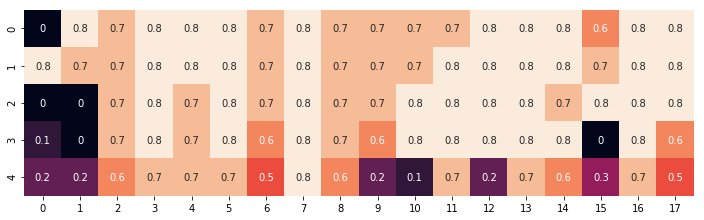

In [117]:
plt.figure(figsize=(12,14))
print(df.columns)
sns.heatmap(np.round(clf.cluster_centers_, 1), annot=True, square=True, cbar=False)

In [113]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
pca = TSNE(n_components=2, random_state=42, init='pca')

scaler = MinMaxScaler(feature_range=(0,1))
d = pca.fit_transform(scaler.fit_transform(df))

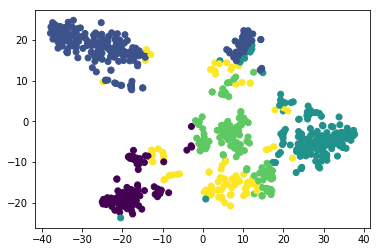

In [116]:
plt.scatter(d[:,0], d[:,1], c=clf.labels_)

## Бонус секция

Можно найти центры кластеров по фотографиям людей....

In [322]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, 
                resize=0.4)

INFO:sklearn.datasets.lfw:Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
INFO:sklearn.datasets.lfw:Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
INFO:sklearn.datasets.lfw:Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
INFO:sklearn.datasets.lfw:Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Ariel Sharon: 77 photos.
Colin Powell: 236 photos.
Donald Rumsfeld: 121 photos.
George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.
Hugo Chavez: 71 photos.
Jacques Chirac: 52 photos.
Jean Chretien: 55 photos.
John Ashcroft: 53 photos.
Junichiro Koizumi: 60 photos.
Serena Williams: 52 photos.
Tony Blair: 144 photos.


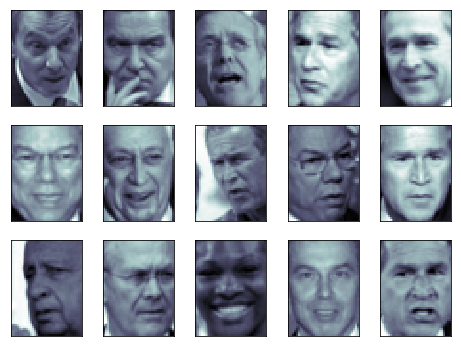

In [350]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

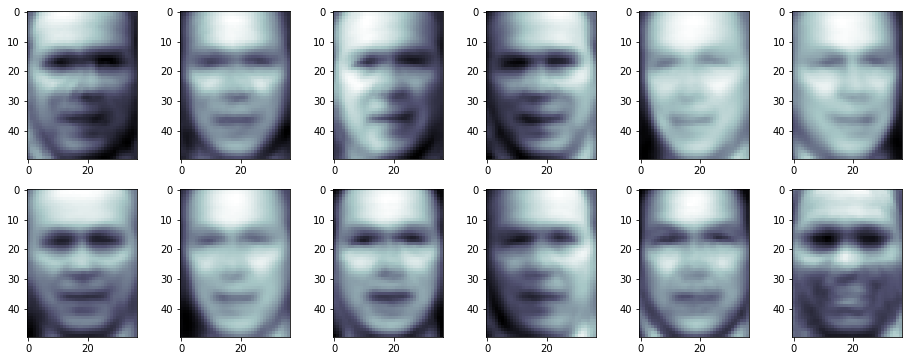

In [346]:
k = KMeans(n_clusters=12, random_state=42, n_init=50)
k.fit(lfw_people.data)

plt.figure(figsize=(16, 6))

for i, center in enumerate(k.cluster_centers_):
    plt.subplot(2, 6, i + 1)
    plt.imshow(center[:].reshape([50,37]), cmap='bone')

.

.

.

.

.

.

.

.

.
## Бонусная секция

Анализ изменений стандартов красоты девушек на основе статистики журнала Playboy за последние 55 лет.

Мы с вами проверим, можно ли с помощью KMeans определить кластеры по размерам и соотнести их с годом.

In [202]:
data = pd.read_csv('../../data/girls.csv')
data.head()

,Month,Year,Bust,Waist,Hips,Height,Weight
0,December,1953,91,61,91,165,54
1,March,1954,86,61,89,168,54
2,July,1955,91,61,91,166,52
3,December,1955,91,61,91,166,52
4,July,1956,91,61,86,157,48


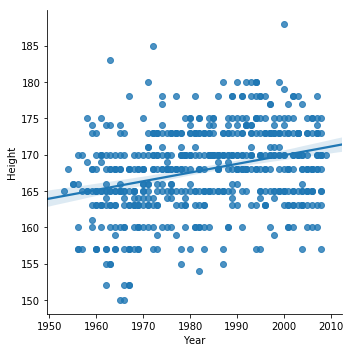

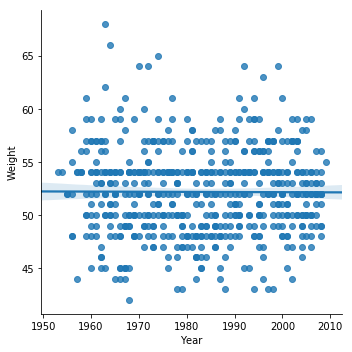

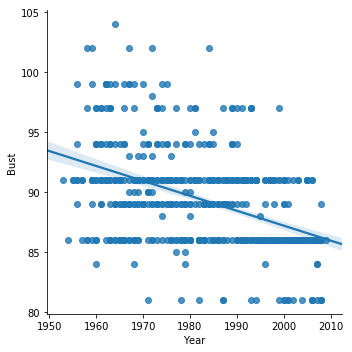

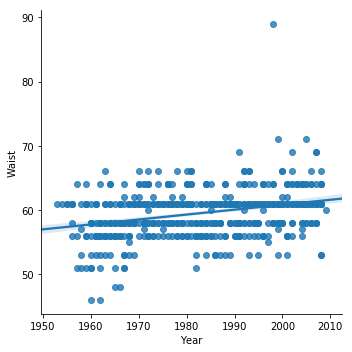

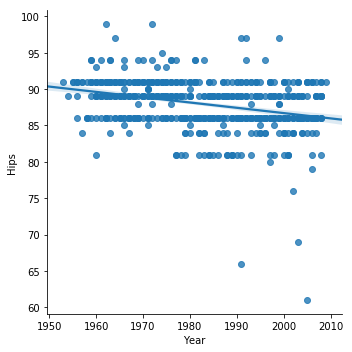

In [279]:
sns.lmplot(x='Year', y='Height', data=data)
sns.lmplot(x='Year', y='Weight', data=data)
sns.lmplot(x='Year', y='Bust',   data=data)
sns.lmplot(x='Year', y='Waist',  data=data)
sns.lmplot(x='Year', y='Hips',   data=data)

Вывод:

|Метрика|Изменение|
|-------|
|Рост|+|
|Вес|=|
|Грудь|-|
|Талия|=|
|Бедра|-|

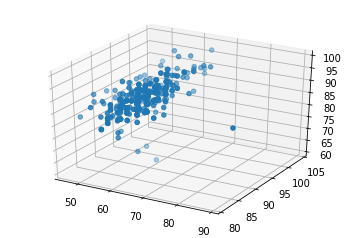

In [280]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Waist'], data['Bust'], data['Hips'])

Ничего не видно на триде графике. Нужно спроецировать его на плоскость каким-то хитрым способом. 

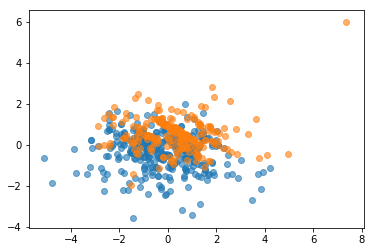

In [212]:
from sklearn.decomposition import PCA  # инструмент понижения размерности
from sklearn.preprocessing import RobustScaler  # нормальзация признаков

pca = PCA(n_components=2)
s = RobustScaler()
p = pca.fit_transform(s.fit_transform(data[['Bust','Waist','Hips', 'Height', 'Weight']]))

data['px'] = p[:,0]
data['py'] = p[:,1]

date = 1990
old = data[data['Year'] < date]
new = data[data['Year'] >= date]
plt.scatter(old['px'], old['py'], alpha=0.6)
plt.scatter(new['px'], new['py'], alpha=0.6)

4


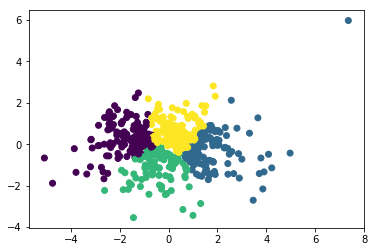

In [275]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=4)
x = data[['Bust','Waist','Hips', 'Height', 'Weight']]
clf.fit(s.fit_transform(x))

data['label'] = clf.labels_
plt.scatter(data['px'], data['py'], c=clf.labels_)
print(len(set(clf.labels_)))

,Bust,Waist,Hips,Height,Weight
label,,,,,
0,87.076923,56.250000,84.967949,163.339744,47.839744
1,91.992857,62.892857,90.728571,172.457143,56.514286
2,92.448598,56.794393,89.616822,167.869159,53.112150
3,87.452736,61.189055,87.417910,168.243781,52.000000


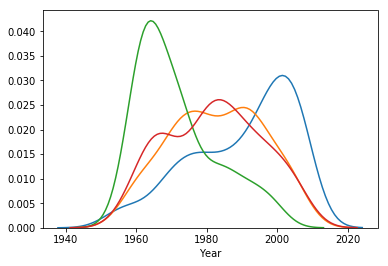

In [276]:
for i in data['label'].unique():
    sns.distplot(data[data['label'] == i]['Year'],hist=False)
data.groupby('label')[['Bust', 'Waist', 'Hips', 'Height', 'Weight']].mean()